Extract sources from image ( at least 5)

In [40]:
!pip install --upgrade photutils


Defaulting to user installation because normal site-packages is not writeable


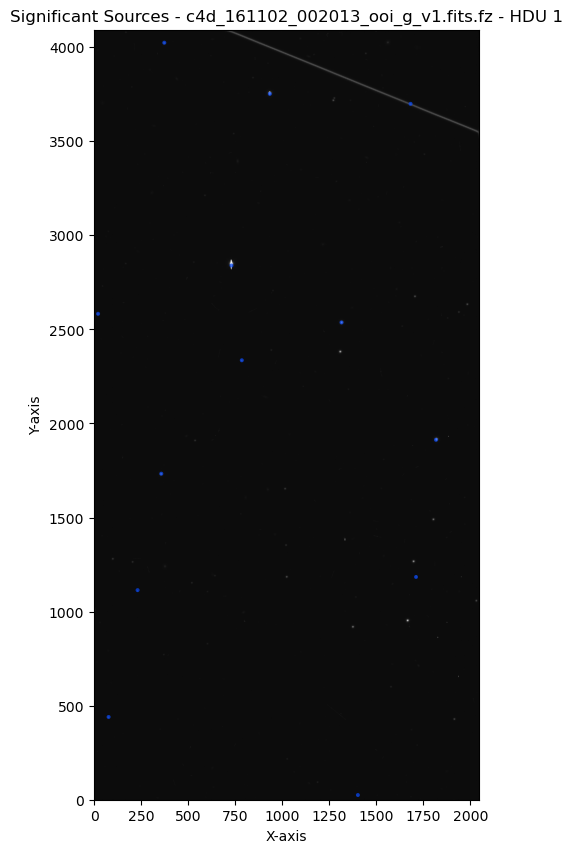

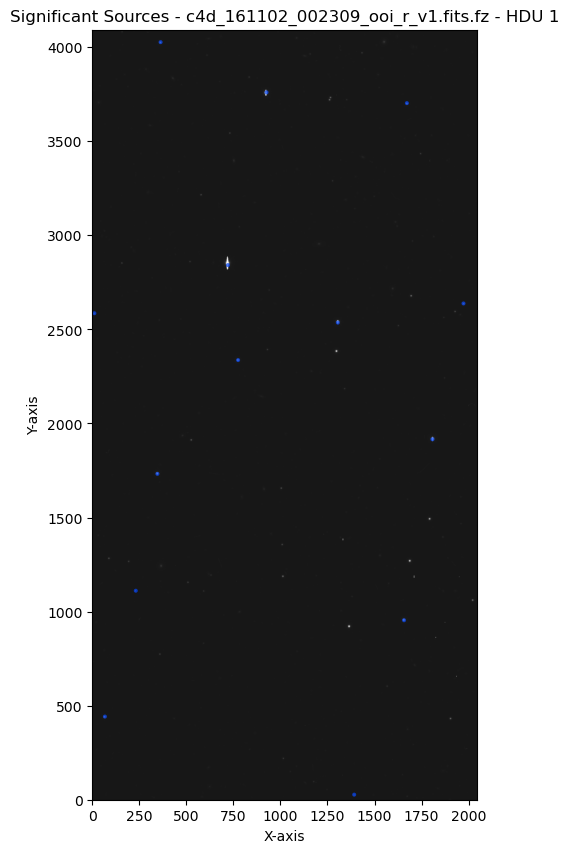

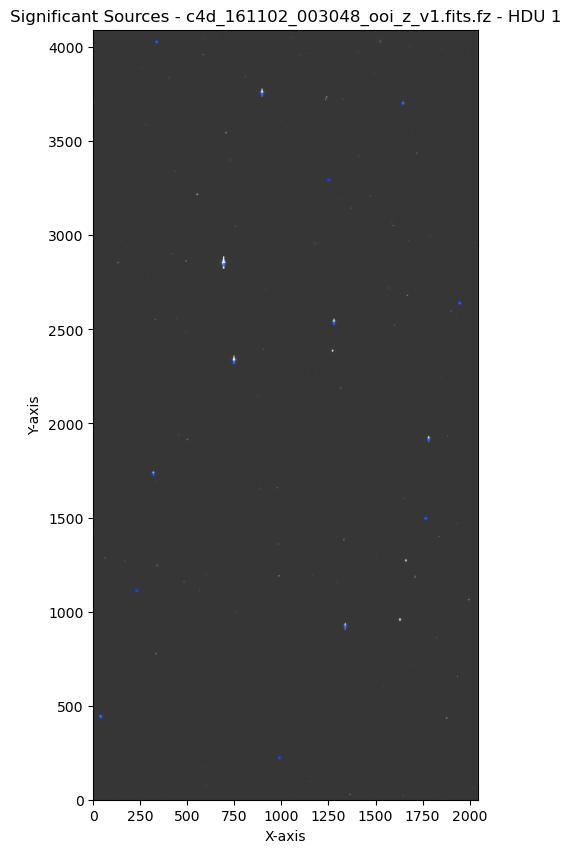

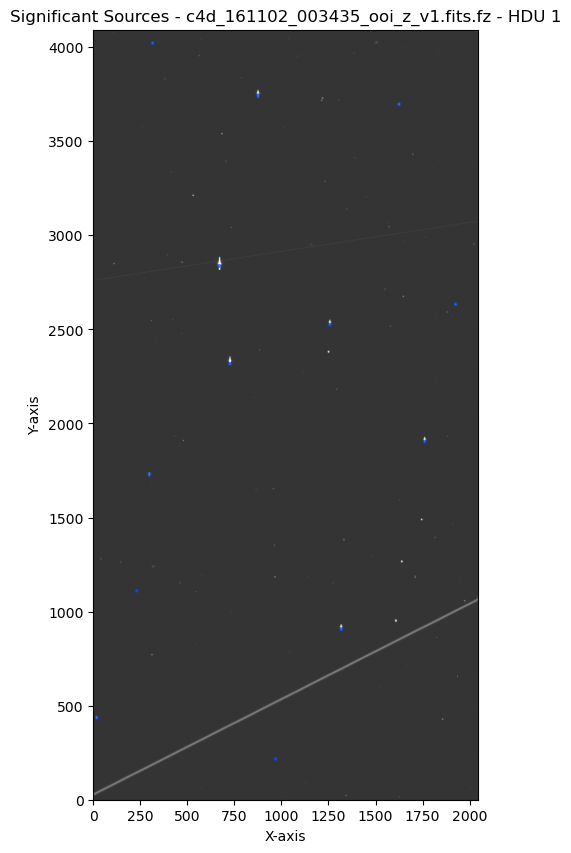

In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, SqrtStretch
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
import numpy as np
from astropy.table import Table

# Constants
THRESHOLD_MULTIPLIER = 200.0  # Adjust the threshold as needed

# File paths (adjust these accordingly)
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

def process_image(image_path, image_hdu, threshold_multiplier=200.0):
    with fits.open(image_path) as hdulist:
        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data
        mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

        # Background subtraction
        sigma_clip = SigmaClip(sigma=5.0)
        sexbkg = SExtractorBackground(sigma_clip)
        bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
        image_data_subtracted = image_data - bkg.background

        # Find sources using find_peaks
        threshold = median + (threshold_multiplier * std)
        box_size = 800  # Increase the box size for a larger search region
        tbl = find_peaks(image_data_subtracted, threshold, box_size=box_size)

        # Get the most significant sources (top 7)
        tbl.sort('peak_value', reverse=True)
        significant_sources = tbl[:7]

        # Plot the original image with the significant sources
        plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu)

def plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu):
    fig, axs = plt.subplots(figsize=(12, 10))
    norm = ImageNormalize(stretch=SqrtStretch())
    im = axs.imshow(image_data_subtracted, cmap='gray', norm=norm)

    # Plot circles around the significant sources
    positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
    apertures = CircularAperture(positions, r=5.0)
    apertures.plot(color='#0547f9', lw=1.5, alpha=0.7)

    # Customize plot details
    axs.set_title(f'Significant Sources - {os.path.basename(image_path)} - HDU {image_hdu}')
    axs.set_xlim(0, image_data_subtracted.shape[1] - 1)
    axs.set_ylim(0, image_data_subtracted.shape[0] - 1)
    axs.set_xlabel('X-axis')
    axs.set_ylabel('Y-axis')
    plt.show()

# Read the image table
image_table = Table.read(fits_file_path)

# Loop through the first 4 rows for display
for index, row in enumerate(image_table[:4]):
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    process_image(image_path, image_hdu)


In [3]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, SqrtStretch
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from photutils.psf import PSFPhotometry, IntegratedGaussianPRF, extract_stars
from astropy.nddata import NDData, StdDevUncertainty
import numpy as np
from astropy.table import Table

# Constants
THRESHOLD_MULTIPLIER = 200.0  # Adjust the threshold as needed

# File paths (adjust these accordingly)
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

def process_image(image_data, image_path, image_hdu):
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

    # Background subtraction
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
    image_data_subtracted = image_data - bkg.background

    # Find sources using find_peaks
    threshold = median + (THRESHOLD_MULTIPLIER * std)
    box_size = 800  # Increase the box size for a larger search region
    tbl = find_peaks(image_data_subtracted, threshold, box_size=box_size)

    # Get the most significant sources (top 7)
    tbl.sort('peak_value', reverse=True)
    significant_sources = tbl[:7]

    # Plot the original image with the significant sources
    plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu)

    # Convert image_data_subtracted to NDData object
    error = np.ones_like(image_data_subtracted)  # You need to replace this with the actual error values
    uncertainty = StdDevUncertainty(error)
    nddata_subtracted = NDData(data=image_data_subtracted, uncertainty=uncertainty)

    return nddata_subtracted, significant_sources

def plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu):
    fig, axs = plt.subplots(figsize=(12, 10))
    norm = ImageNormalize(stretch=SqrtStretch())
    im = axs.imshow(image_data_subtracted, cmap='gray', norm=norm)

    # Plot circles around the significant sources
    positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
    apertures = CircularAperture(positions, r=5.0)
    apertures.plot(color='#0547f9', lw=1.5, alpha=0.7)

    # Customize plot details
    axs.set_title(f'Significant Sources - {os.path.basename(image_path)} - HDU {image_hdu}')
    axs.set_xlim(0, image_data_subtracted.shape[1] - 1)
    axs.set_ylim(0, image_data_subtracted.shape[0] - 1)
    axs.set_xlabel('X-axis')
    axs.set_ylabel('Y-axis')
    plt.show()
    
def fit_psf(image_data_subtracted, significant_sources):
    positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
    star_cutouts = extract_stars(image_data_subtracted, positions, size=25)

    # Create a PSF model (Gaussian, for example)
    psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
    fit_shape = (5, 5)
    finder = DAOStarFinder(6.0, 2.0)

    # Fit PSF for each star cutout
    for star_cutout in star_cutouts:
        # Convert star_cutout to an NDData object with StdDevUncertainty
        error = np.ones_like(star_cutout.data)  # You need to replace this with the actual error values
        uncertainty = StdDevUncertainty(error)
        nddata = NDData(data=star_cutout.data, uncertainty=uncertainty)

        # PSF Photometry
        psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=4)
        phot = psfphot(nddata)

        # Print the result table
        phot['x_fit'].info.format = '.4f'
        phot['y_fit'].info.format = '.4f'
        phot['flux_fit'].info.format = '.4f'
        print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

        # Plot the fitted PSF
        fig, axs = plt.subplots(figsize=(12, 10))
        norm = ImageNormalize(image_data_subtracted, interval=ZScaleInterval())
        im = axs.imshow(image_data_subtracted, cmap='gray', norm=norm)

        # Plot circles around the significant sources
        positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
        apertures = CircularAperture(positions, r=5.0)
        apertures.plot(color='#0547f9', lw=1.5, alpha=0.7)

        # Plot the fitted PSF
        model_psf = psf_model.copy()
        model_psf.amplitude = phot['flux_fit'][0]
        model_psf.x_0 = phot['x_fit'][0]
        model_psf.y_0 = phot['y_fit'][0]
        plt.imshow(model_psf(x, y), cmap='viridis', alpha=0.5)

        axs.set_title(f'Fitted PSF - HDU {image_hdu}')
        axs.set_xlim(0, image_data_subtracted.shape[1] - 1)
        axs.set_ylim(0, image_data_subtracted.shape[0] - 1)
        axs.set_xlabel('X-axis')
        axs.set_ylabel('Y-axis')
        plt.show()




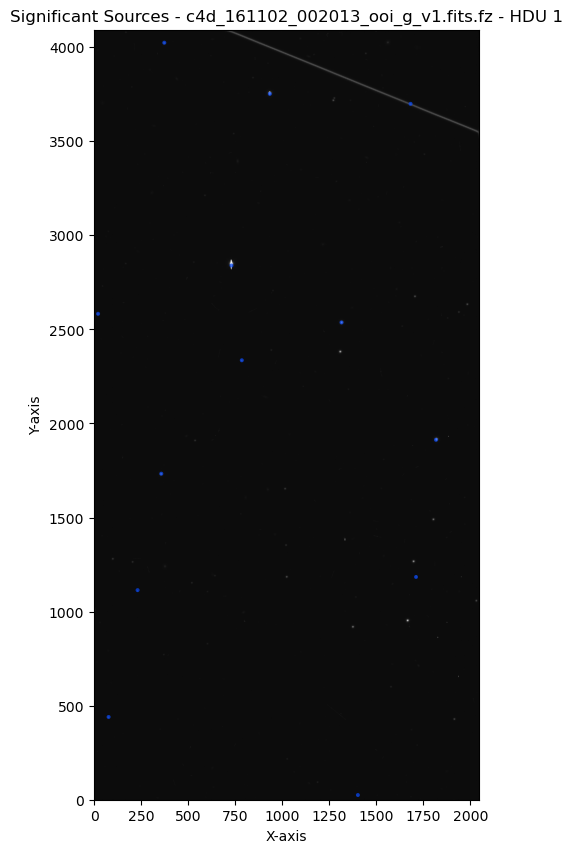

ValueError: catalogs must be a single or list of Table objects.

In [4]:

# Read the image table
image_table = Table.read(fits_file_path)

# Loop through the first 4 rows for display
for index, row in enumerate(image_table[:4]):
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    with fits.open(image_path) as hdulist:
        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data

        # Process image
        image_data_subtracted, significant_sources = process_image(image_data, image_path, image_hdu)

        # Fit PSF
        fit_psf(image_data_subtracted, significant_sources)

In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, SqrtStretch
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from photutils.psf import PSFPhotometry, IntegratedGaussianPRF, extract_stars
from astropy.nddata import NDData, StdDevUncertainty
import numpy as np
from astropy.table import Table
from photutils.detection import DAOStarFinder

# Constants
THRESHOLD_MULTIPLIER = 200.0  # Adjust the threshold as needed

# File paths (adjust these accordingly)
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

def process_image(image_data, image_path, image_hdu):
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

    # Background subtraction
    sigma_clip = SigmaClip(sigma=5.0)
    sexbkg = SExtractorBackground(sigma_clip)
    bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
    image_data_subtracted = image_data - bkg.background

    # Find sources using find_peaks
    threshold = median + (THRESHOLD_MULTIPLIER * std)
    box_size = 800  # Increase the box size for a larger search region
    tbl = find_peaks(image_data_subtracted, threshold, box_size=box_size)

    # Get the most significant sources (top 7)
    tbl.sort('peak_value', reverse=True)
    significant_sources = tbl[:7]

    # Plot the original image with the significant sources
    plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu)

    # Convert image_data_subtracted to NDData object
    error = np.ones_like(image_data_subtracted)  # You need to replace this with the actual error values
    uncertainty = StdDevUncertainty(error)
    nddata_subtracted = NDData(data=image_data_subtracted, uncertainty=uncertainty)

    return nddata_subtracted, significant_sources

def plot_image_with_sources(image_data_subtracted, tbl, image_path, image_hdu):
    fig, axs = plt.subplots(figsize=(12, 10))
    norm = ImageNormalize(stretch=SqrtStretch())
    im = axs.imshow(image_data_subtracted, cmap='gray', norm=norm)

    # Plot circles around the significant sources
    positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
    apertures = CircularAperture(positions, r=5.0)
    apertures.plot(color='#0547f9', lw=1.5, alpha=0.7)

    # Customize plot details
    axs.set_title(f'Significant Sources - {os.path.basename(image_path)} - HDU {image_hdu}')
    axs.set_xlim(0, image_data_subtracted.shape[1] - 1)
    axs.set_ylim(0, image_data_subtracted.shape[0] - 1)
    axs.set_xlabel('X-axis')
    axs.set_ylabel('Y-axis')
    plt.show()

def fit_psf(image_data_subtracted, significant_sources):
    positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
    star_cutouts = extract_stars(image_data_subtracted, positions, size=25)

    # Create a PSF model (Gaussian, for example)
    psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
    fit_shape = (5, 5)
    finder = DAOStarFinder(6.0, 2.0)

    # Fit PSF for each star cutout
    for star_cutout in star_cutouts:
        # Convert star_cutout to an NDData object with StdDevUncertainty
        error = np.ones_like(star_cutout.data)  # You need to replace this with the actual error values
        uncertainty = StdDevUncertainty(error)
        nddata = NDData(data=star_cutout.data, uncertainty=uncertainty)

        # PSF Photometry
        psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=4)
        phot = psfphot(nddata)

        # Print the result table
        phot['x_fit'].info.format = '.4f'
        phot['y_fit'].info.format = '.4f'
        phot['flux_fit'].info.format = '.4f'
        print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

        # Plot the fitted PSF
        fig, axs = plt.subplots(figsize=(12, 10))
        norm = ImageNormalize(image_data_subtracted, interval=ZScaleInterval())
        im = axs.imshow(image_data_subtracted, cmap='gray', norm=norm)

        # Plot circles around the significant sources
        positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
        apertures = CircularAperture(positions, r=5.0)
        apertures.plot(color='#0547f9', lw=1.5, alpha=0.7)

        # Plot the fitted PSF
        model_psf = psf_model.copy()
        model_psf.amplitude = phot['flux_fit'][0]
        model_psf.x_0 = phot['x_fit'][0]
        model_psf.y_0 = phot['y_fit'][0]
        plt.imshow(model_psf(x, y), cmap='viridis', alpha=0.5)

        axs.set_title(f'Fitted PSF - HDU {image_hdu}')
        axs.set_xlim(0, image_data_subtracted.shape[1] - 1)
        axs.set_ylim(0, image_data_subtracted.shape[0] - 1)
        axs.set_xlabel('X-axis')
        axs.set_ylabel('Y-axis')
        plt.show()

# Load fits file and get data
hdulist = fits.open(fits_file_path)
image_data = hdulist[0].data

# Choose an example image and HDU index
example_image_path = os.path.join(image_base_path, 'example_image.fits')
example_image_hdu = 0

# Process the image and get significant sources
image_data_subtracted, significant_sources = process_image(image_data, example_image_path, example_image_hdu)

# Fit PSF
fit_psf(image_data_subtracted, significant_sources)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Calculate the flux

(324.714, 324.61566, 9.563577)
Source 1 Flux: 3245724.5161379077
Source 2 Flux: 3866742.8689871277
Source 3 Flux: 4007457.4957713764
Source 4 Flux: 3159247.823103814
Source 5 Flux: 293246.4653352368


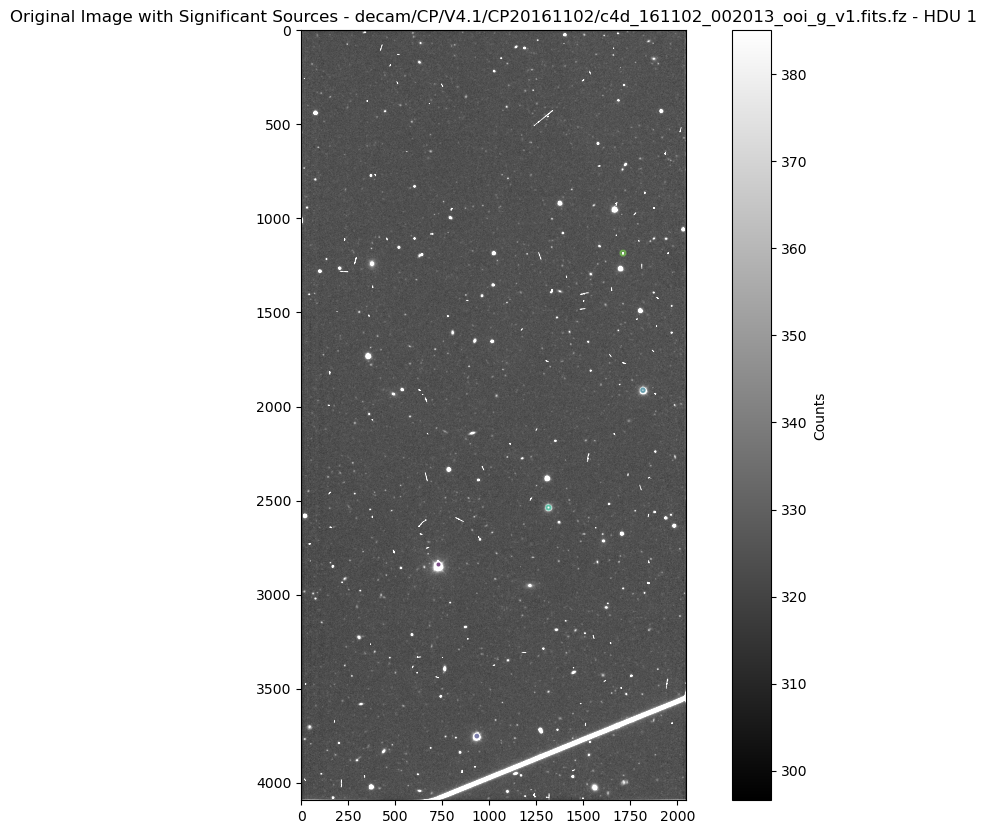

(604.4093, 604.3065, 13.088086)
Source 1 Flux: 3718060.916990682
Source 2 Flux: 5861232.185156234
Source 3 Flux: 5657747.9105727505
Source 4 Flux: 6146058.184600564
Source 5 Flux: 5661660.639123661


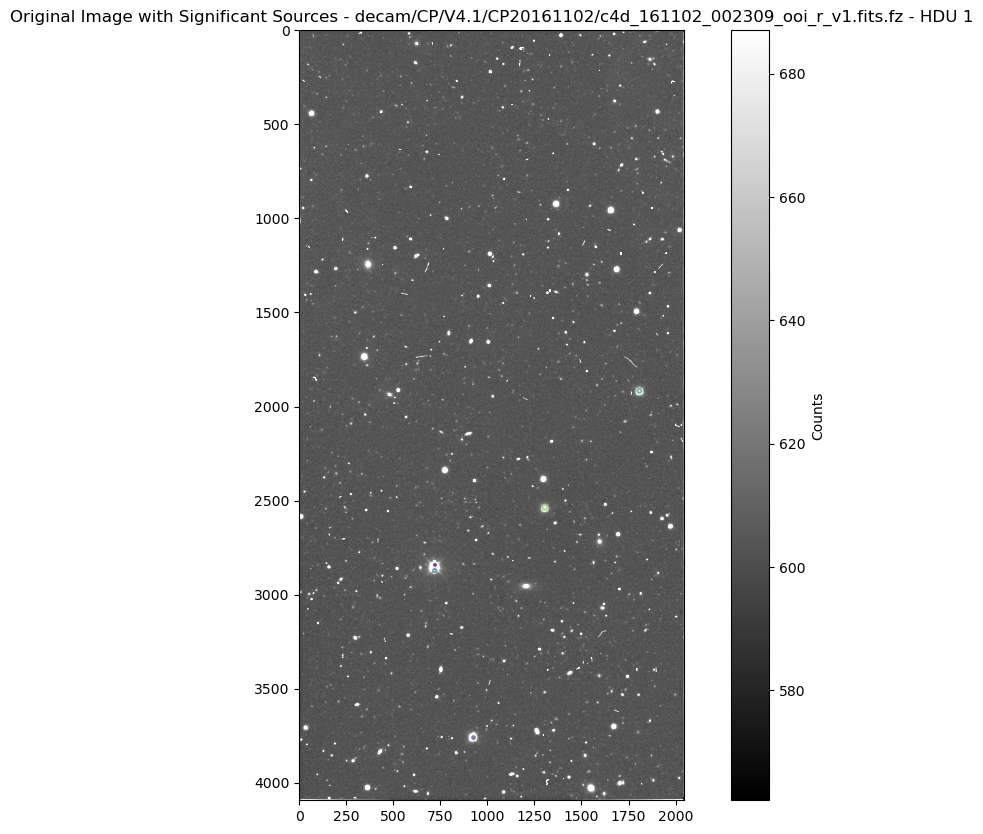

In [10]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture, aperture_photometry
import numpy as np

# Constants
THRESHOLD_MULTIPLIER = 4.0  # Adjust the threshold as needed

# File paths
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

# Background estimation
sigma_clip = SigmaClip(sigma=5.0)
sexbkg = SExtractorBackground(sigma_clip)

# Loop through the first 2 rows for display
for row in image_table[:2]:
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']

    # Create the full path to the image
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    with fits.open(image_path) as hdulist:

        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data
        mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
        print((mean, median, std))

        # Background subtraction
        bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
        image_data_subtracted = image_data - bkg.background

        # Find sources using find_peaks
        threshold = median + (THRESHOLD_MULTIPLIER * std)
        box_size = 21  # Increase the box size for a larger search region
        tbl = find_peaks(image_data, threshold, box_size=box_size)

        # Get the most significant sources (top 5)
        tbl.sort('peak_value', reverse=True)
        significant_sources = tbl[:5]

        # Loop through significant sources
        for i, source in enumerate(significant_sources):
            x, y = source['x_peak'], source['y_peak']
            aperture_radius = 5.0 + i * 2.0

            # Create a circular aperture
            aperture = CircularAperture((x, y), r=aperture_radius)

            # Perform aperture photometry
            phot_table = aperture_photometry(image_data_subtracted, aperture)
            flux = phot_table['aperture_sum'][0]

            # Print or use the flux as needed
            print(f"Source {i + 1} Flux: {flux}")

        # Plot the original image with the significant sources
        fig, axs = plt.subplots(figsize=(12, 10))
        norm = ImageNormalize(image_data, interval=ZScaleInterval())
        im = axs.imshow(image_data, cmap='gray', norm=norm)

        # Plot circles around the significant sources
        positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
        for i, (x, y) in enumerate(positions):
            aperture_radius = 5.0 + i * 2.0  # Increase the aperture size for better visibility
            color = plt.cm.viridis(i / len(positions))  # Use different colors for each source
            aperture = CircularAperture((x, y), r=aperture_radius)
            aperture.plot(ax=axs, color=color, lw=1.5, alpha=0.7)

        axs.set_title(f'Original Image with Significant Sources - {image_filename} - HDU {image_hdu}')
        fig.colorbar(im, ax=axs, label='Counts')
        plt.show()

        

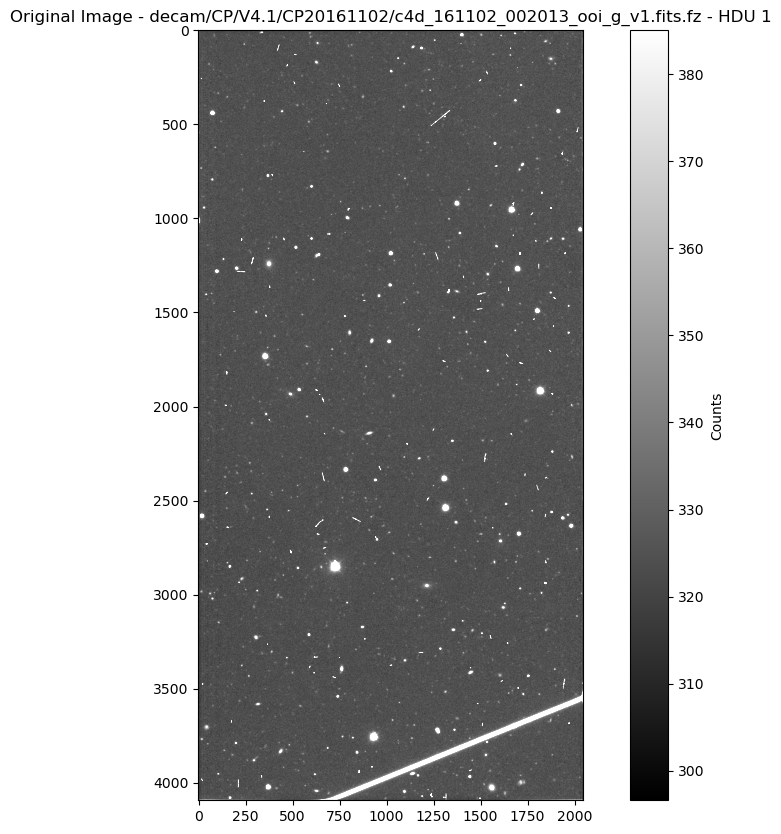

        Use `photutils.psf.PSFPhotometry` instead. [warnings]


TypeError: BasicPSFPhotometry.__init__() got an unexpected keyword argument 'niters'

In [5]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import DAOStarFinder, find_peaks
from photutils.psf import IterativePSFPhotometry
from photutils.psf import IntegratedGaussianPRF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import BasicPSFPhotometry
from astropy.modeling.models import Gaussian2D
import numpy as np
from astropy.table import Table
from photutils.psf import SourceGrouper

# Constants
THRESHOLD_MULTIPLIER = 4.0  # Adjust the threshold as needed

def display_image(image, title):
    fig, axs = plt.subplots(figsize=(12, 10))
    norm = ImageNormalize(image, interval=ZScaleInterval())
    im = axs.imshow(image, cmap='gray', norm=norm)
    axs.set_title(title)
    fig.colorbar(im, ax=axs, label='Counts')
    plt.show()

def sync_shift(image, source_position):
    # Implement sync-shifting if needed
    return image

# File paths
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'
image_table = Table.read(fits_file_path)

# Background estimation
sigma_clip = SigmaClip(sigma=5.0)
sexbkg = SExtractorBackground(sigma_clip)

# Loop through the first 2 rows for display
for row in image_table[:2]:
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']

    # Create the full path to the image
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    with fits.open(image_path) as hdulist:

        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data
        display_image(image_data, f'Original Image - {image_filename} - HDU {image_hdu}')

        # Background subtraction
        bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
        image_data_subtracted = image_data - bkg.background

        # Find sources using DAOStarFinder
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * np.std(image_data_subtracted))
        sources = daofind(image_data_subtracted)

        # PSF Photometry
        psf_model = IntegratedGaussianPRF()
        fitter = LevMarLSQFitter()
        grouper = SourceGrouper(min_separation=20)

        photometry = BasicPSFPhotometry(group_maker=grouper, finder=daofind,
                                        psf_model=psf_model, fitter=fitter, fitshape=(11, 11), niters=3)
        result_tab = photometry(image=image_data_subtracted)

        # Further aperture correction based on seeing
        seeing = 2.5  # Replace with actual seeing value
        aperture_radius = 7.4  # Replace with actual aperture radius
        flux = result_tab['flux_fit']
        corrected_flux = flux * (aperture_radius / seeing)**2

        print(f"Corrected Flux: {corrected_flux}")

        # Plot the original image with the detected sources
        fig, axs = plt.subplots(figsize=(12, 10))
        norm = ImageNormalize(image_data, interval=ZScaleInterval())
        im = axs.imshow(image_data, cmap='gray', norm=norm)

        # Plot circles around the detected sources
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        for i, (x, y) in enumerate(positions):
            aperture_radius = 5.0 + i * 2.0  # Increase the aperture size for better visibility
            color = plt.cm.viridis(i / len(positions))  # Use different colors for each source
            aperture = CircularAperture((x, y), r=aperture_radius)
            aperture.plot(ax=axs, color=color, lw=1.5, alpha=0.7)

        axs.set_title(f'Original Image with Detected Sources - {image_filename} - HDU {image_hdu}')
        fig.colorbar(im, ax=axs, label='Counts')
        plt.show()


Astropy method 

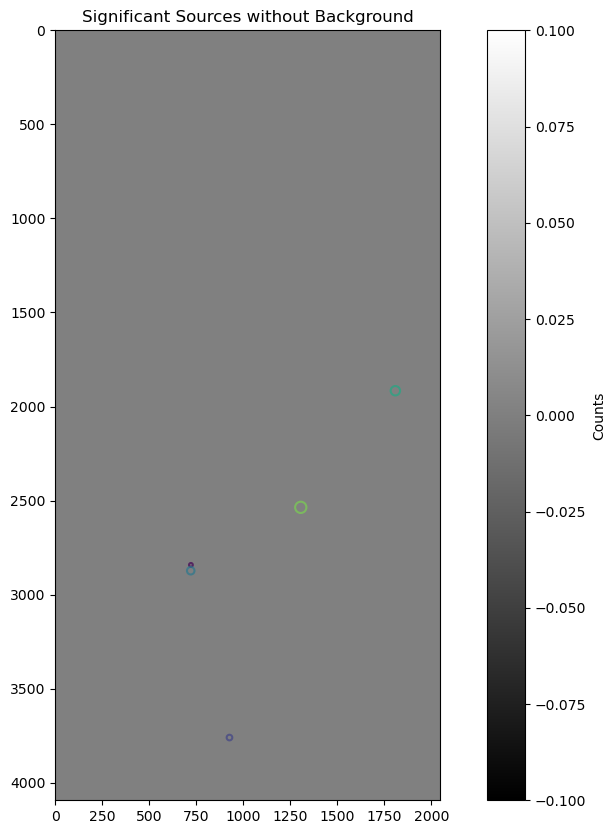

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.aperture import CircularAperture

# Assuming `significant_sources` is a table or array with extracted sources
# The table should have columns like 'x_peak', 'y_peak' for source positions

# Create a blank background
blank_background = np.zeros_like(image_data)

# Plot the sources on the blank background
fig, axs = plt.subplots(figsize=(12, 10))
norm = ImageNormalize(blank_background, interval=ZScaleInterval())
im = axs.imshow(blank_background, cmap='gray', norm=norm)

# Plot circles around the significant sources
positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
for i, (x, y) in enumerate(positions):
    aperture_radius = 10.0 + i * 5.0  # Increase the aperture size for better visibility
    color = plt.cm.viridis(i / len(positions))  # Use different colors for each source
    aperture = CircularAperture((x, y), r=aperture_radius)
    aperture.plot(ax=axs, color=color, lw=1.5, alpha=0.7)

axs.set_title(f'Significant Sources without Background')
fig.colorbar(im, ax=axs, label='Counts')
plt.show()


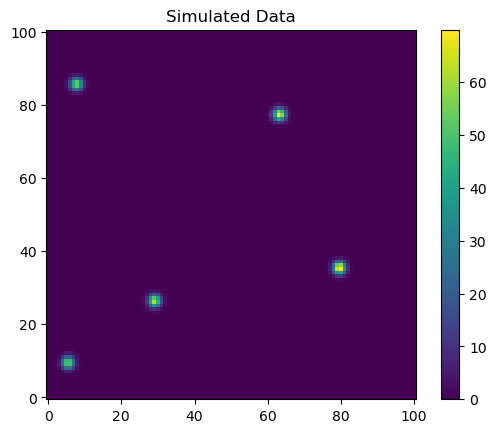

In [45]:
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image, make_test_psf_data
from photutils.psf import IntegratedGaussianPRF

psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
psf_shape = (9, 9)
nsources = 5
shape = (101, 101)
data, true_params = make_test_psf_data(shape, psf_model, psf_shape,
                                       nsources, flux_range=(500, 700),
                                       min_separation=10, seed=0)
plt.imshow(data, origin='lower')
plt.title('Simulated Data')
plt.colorbar()

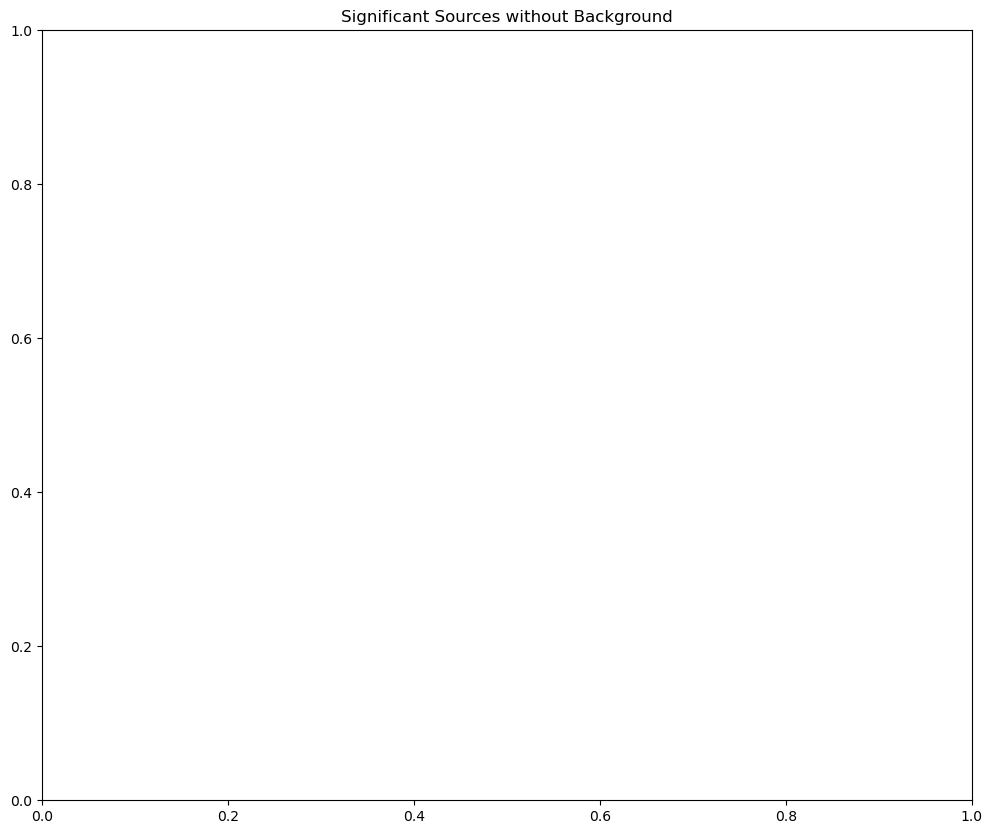

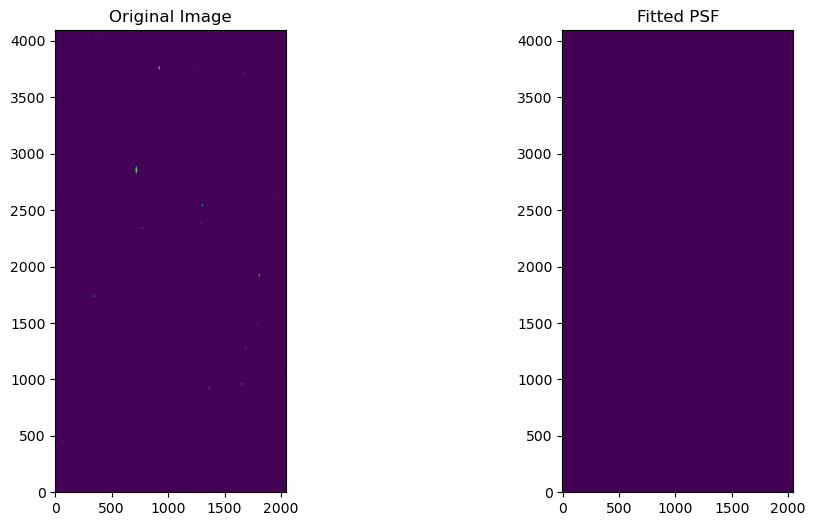

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Assuming `significant_sources` is a table or array with extracted sources
# The table should have columns like 'x_peak', 'y_peak' for source positions

# Create a blank background
blank_background = np.zeros_like(image_data)

# Plot the sources on the blank background
fig, axs = plt.subplots(figsize=(12, 10))

# Plot circles around the significant sources on the blank background
positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
for i, (x, y) in enumerate(positions):
    aperture_radius = 5.0 + i * 2.0  # Increase the aperture size for better visibility
    color = plt.cm.viridis(i / len(positions))  # Use different colors for each source
    aperture = CircularAperture((x, y), r=aperture_radius)
    aperture.plot(ax=axs, color=color, lw=1.5, alpha=0.7)

axs.set_title('Significant Sources without Background')

# Fit a 2D Gaussian model to the data
y, x = np.mgrid[:blank_background.shape[0], :blank_background.shape[1]]
gauss_init = models.Gaussian2D(amplitude=np.max(blank_background + image_data), x_mean=50, y_mean=50, x_stddev=2, y_stddev=2)
fit_gauss = fitting.LevMarLSQFitter()
gauss_fit = fit_gauss(gauss_init, x, y, blank_background + image_data)

# Display original image
fig, axs_fit = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axs_fit[0].imshow(image_data, cmap='viridis', origin='lower', vmin=np.min(image_data), vmax=np.max(image_data))
axs_fit[0].set_title('Original Image')

# Display the fitted PSF
axs_fit[1].imshow(gauss_fit(x, y), cmap='viridis', origin='lower', vmin=np.min(image_data), vmax=np.max(image_data))
axs_fit[1].set_title('Fitted PSF')

plt.show()


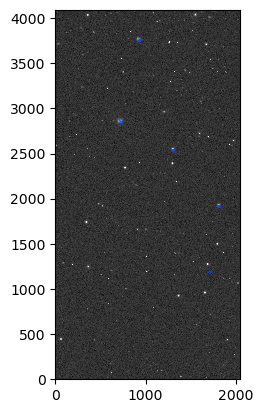

In [56]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from astropy.modeling import models, fitting
import numpy as np

# Constants
THRESHOLD_MULTIPLIER = 4.0  # Adjust the threshold as needed

# File paths
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

# Background estimation
sigma_clip = SigmaClip(sigma=5.0)
sexbkg = SExtractorBackground(sigma_clip)

# Loop through the first 2 rows for display
for row in image_table[:2]:
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']

    # Create the full path to the image
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    with fits.open(image_path) as hdulist:

        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data
        mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

        # Background subtraction
        bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
        image_data_subtracted = image_data - bkg.background

        # Find sources using find_peaks
        threshold = median + (THRESHOLD_MULTIPLIER * std)
        box_size = 21  # Increase the box size for a larger search region
        tbl = find_peaks(image_data, threshold, box_size=box_size)

        # Get the most significant sources (top 5)
        tbl.sort('peak_value', reverse=True)
        significant_sources = tbl[:5]

        # Plot circles around the significant sources using CircularAperture
        positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
        apertures = CircularAperture(positions, r=5.0)
        apertures.plot(color='#0547f9', lw=1.5)
        norm = simple_norm(image_data, 'sqrt', percent=99.9)
        plt.imshow(image_data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
        plt.xlim(0, image_data.shape[1] - 1)
        plt.ylim(0, image_data.shape[0] - 1)


(0.0, 100.0)

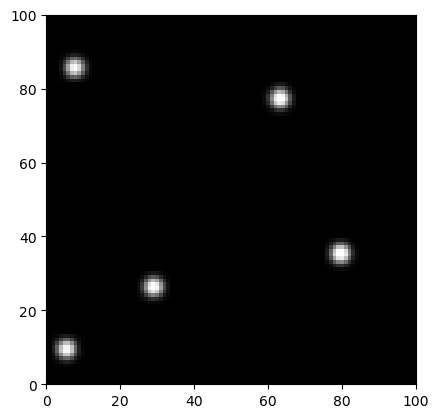

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.0)
norm = simple_norm(data, 'sqrt', percent=99.9)
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='nearest')
plt.xlim(0, data.shape[1] - 1)
plt.ylim(0, data.shape[0] - 1)

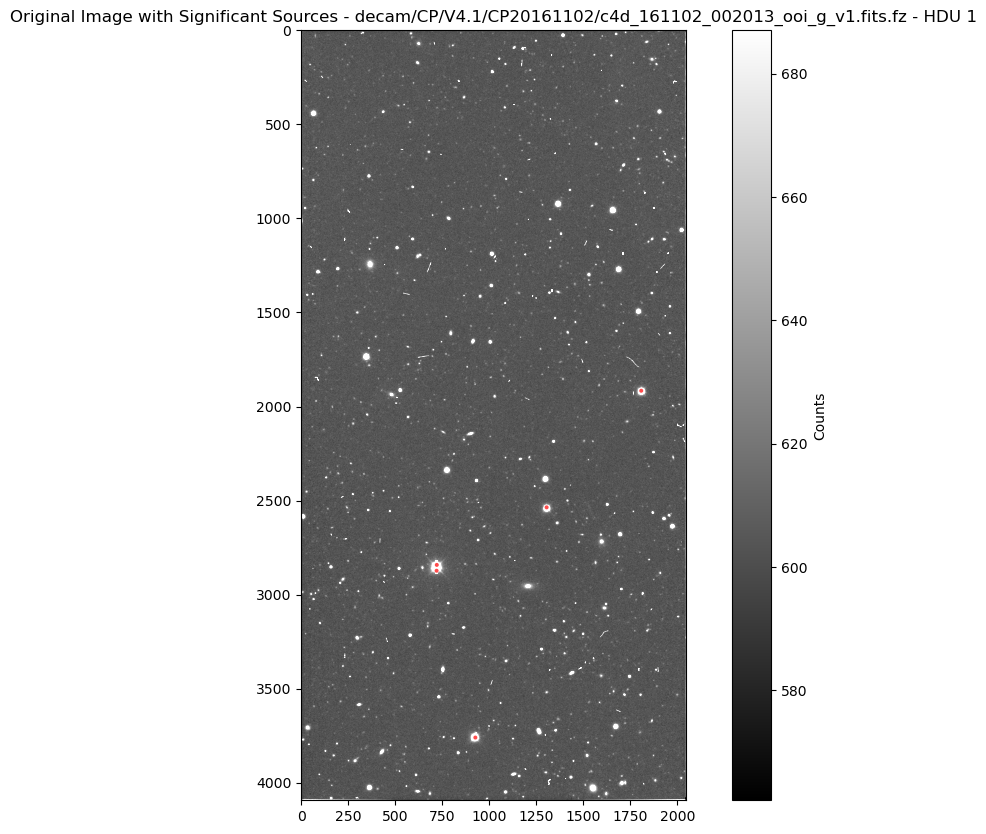

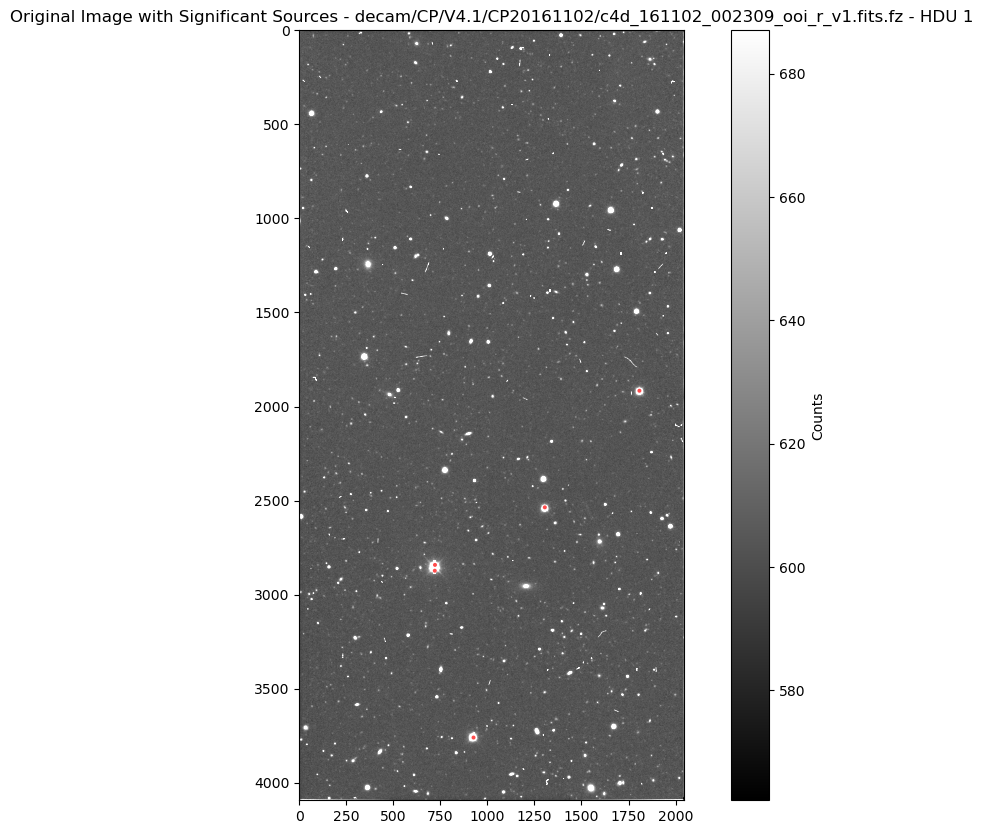

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

# ... (your existing code)

# Loop through the first 2 rows for display
for row in image_table[:2]:
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']

    # ... (rest of your existing code)

    # Get the most significant sources (top 5)
    tbl.sort('peak_value', reverse=True)
    significant_sources = tbl[:5]
    # Plot circles around the significant sources using CircularAperture
    positions = np.transpose((significant_sources['x_peak'], significant_sources['y_peak']))
    apertures = CircularAperture(positions, r=5.0)
    norm = simple_norm(image_data, 'sqrt', percent=99.9)
    plt.imshow(image_data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
    plt.xlim(0, image_data.shape[1] - 1)
    plt.ylim(0, image_data.shape[0] - 1)
    



In [ ]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import simple_norm
from photutils.background import SExtractorBackground, Background2D
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.detection import find_peaks, DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.psf import IntegratedGaussianPRF, IterativePSFPhotometry
from astropy.modeling import models, fitting
from photutils.background import LocalBackground, MMMBackground

# Constants
THRESHOLD_MULTIPLIER = 4.0  # Adjust the threshold as needed
N_SOURCES_TO_FIT = 5  # Number of sources to fit in each image

# File paths
fits_file_path = '/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'
image_base_path = '/global/cfs/cdirs/desicollab/users/brookluo/raw-images/dr9/images'

# Background estimation
sigma_clip = SigmaClip(sigma=5.0)
sexbkg = SExtractorBackground(sigma_clip)

# Loop through the first 2 rows for display
for row in image_table[:2]:
    image_filename = row['image_filename']
    image_hdu = row['image_hdu']

    # Create the full path to the image
    image_path = os.path.join(image_base_path, image_filename)

    if not os.path.exists(image_path):
        print(f'File not found: {image_path}')
        continue

    with fits.open(image_path) as hdulist:

        # Display the first HDU (image) with Z-scaled normalization
        image_data = hdulist[image_hdu].data
        mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

        # Background subtraction
        bkg = Background2D(image_data, (60, 60), filter_size=(3, 3), bkg_estimator=sexbkg)
        image_data_subtracted = image_data - bkg.background

        # Find sources using DAOStarFinder
        fwhm = 2.0  # Replace with the actual FWHM value for your data
        daofind = DAOStarFinder(threshold=THRESHOLD_MULTIPLIER * np.std(image_data_subtracted), fwhm=fwhm)
        sources = daofind(image_data_subtracted)

        # Ensure at least N_SOURCES_TO_FIT sources are found
        if len(sources) < N_SOURCES_TO_FIT:
            print(f'Not enough sources found in {image_filename}. Skipping.')
            continue

        # Fit a PSF to each source using IterativePSFPhotometry
        psf_model = IntegratedGaussianPRF()
        fit_shape = (5, 5)
        fitter = fitting.LevMarLSQFitter()
        finder = DAOStarFinder(10.0, 2.0)
        bkgstat = MMMBackground()
        localbkg_estimator = LocalBackground(5, 10, bkgstat)

        psf_photometry = IterativePSFPhotometry(psf_model, fit_shape, finder=finder,
                                  localbkg_estimator=localbkg_estimator,
                                  aperture_radius=4)

        result_tab = psf_photometry(image_data)

        # Plot the original image with the fitted PSFs
        fig, axs = plt.subplots(figsize=(12, 10))
        im = axs.imshow(image_data, cmap='gray', origin='lower', vmin=np.min(image_data), vmax=np.max(image_data))

        # Plot the fitted PSFs
        for result in result_tab:
            aperture = CircularAperture((result['x_fit'], result['y_fit']), r=5.0)
            aperture.plot(ax=axs, color='red', lw=1.5, alpha=0.7)

        axs.set_title(f'Original Image with Fitted PSFs - {image_filename} - HDU {image_hdu}')
        fig.colorbar(im, ax=axs, label='Counts')
        plt.show()
